# Other Samplers

Trey V. Wenger (c) February 2025

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.21.1
bayes_spec version: 1.7.3+1.g80387bd.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

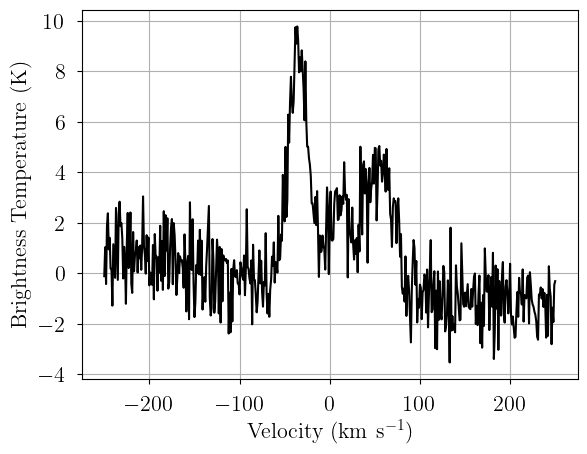

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's try the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 4,
    cores = 4,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Output()

Adding log-likelihood to trace


In [7]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [2 1 0]
Chain 1 order: [2 1 0]
Chain 2 order: [2 0 1]
Chain 3 order: [2 1 0]
Adopting (first) most common order: [2 1 0]


Sampling: [observation]


Output()

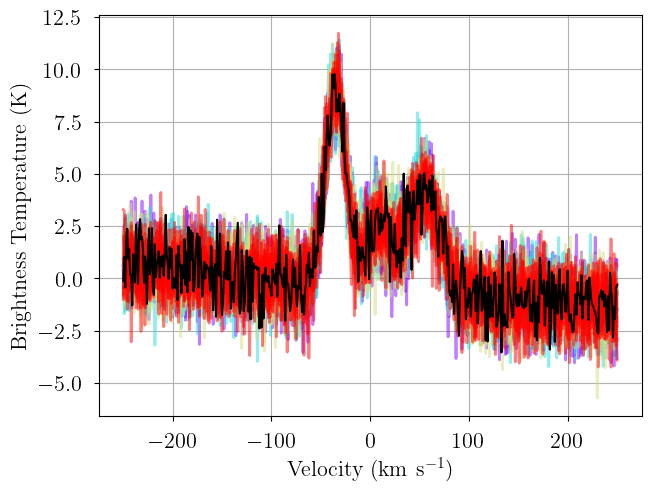

In [8]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

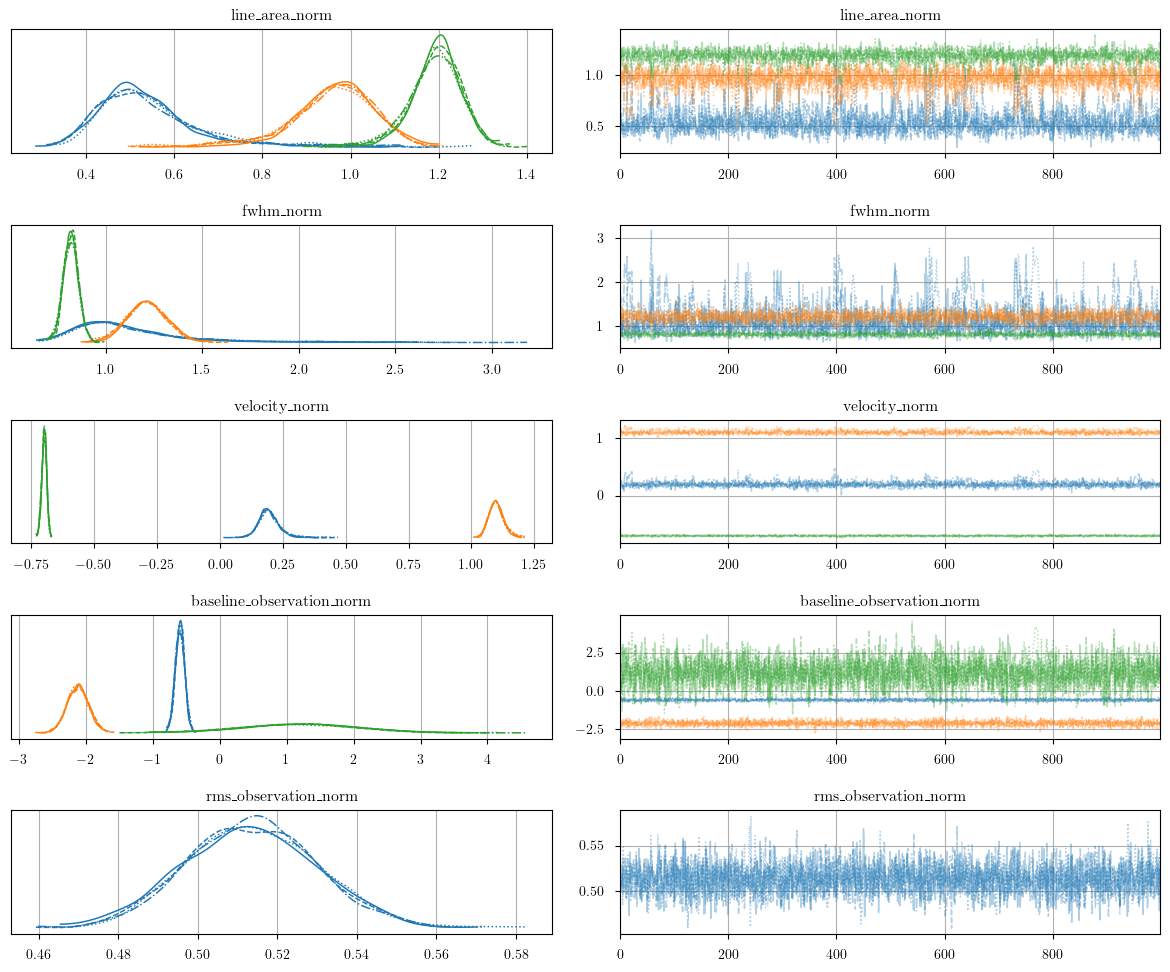

In [9]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [10]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.593   0.070   -0.719   -0.456      0.001   
baseline_observation_norm[1]   -2.116   0.158   -2.409   -1.814      0.003   
baseline_observation_norm[2]    1.190   0.863   -0.404    2.848      0.017   
velocity_norm[0]                0.197   0.045    0.115    0.281      0.001   
velocity_norm[1]                1.100   0.030    1.047    1.159      0.001   
velocity_norm[2]               -0.699   0.010   -0.718   -0.682      0.000   
line_area_norm[0]               0.547   0.129    0.356    0.794      0.005   
line_area_norm[1]               0.958   0.099    0.773    1.140      0.004   
line_area_norm[2]               1.192   0.059    1.080    1.301      0.002   
fwhm_norm[0]                    1.133   0.327    0.692    1.759      0.013   
fwhm_norm[1]                    1.212   0.104    1.019    1.407      0.003   
fwhm_norm[2]                    0.818   0.039    0.741    0.890      0.001   
rms_observation_norm            0.514   0.016    0.483    0.544      0.000   
line_area[0]                  109.323  25.703   71.284  158.801      1.044   
line_area[1]                  191.666  19.762  154.687  227.995      0.769   
line_area[2]                  238.358  11.890  216.074  260.227      0.352   
fwhm[0]                        33.998   9.797   20.755   52.782      0.399   
fwhm[1]                        36.360   3.111   30.565   42.198      0.094   
fwhm[2]                        24.551   1.182   22.221   26.714      0.029   
velocity[0]                     9.862   2.267    5.767   14.055      0.070   
velocity[1]                    55.023   1.508   52.364   57.964      0.050   
velocity[2]                   -34.940   0.486  -35.915  -34.086      0.012   
amplitude[0]                    3.067   0.305    2.507    3.647      0.007   
amplitude[1]                    4.952   0.315    4.420    5.548      0.009   
amplitude[2]                    9.125   0.325    8.488    9.719      0.006   
rms_observation                 1.027   0.033    0.966    1.089      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.001    2750.0    2383.0   1.00  
baseline_observation_norm[1]    0.003    3884.0    2735.0   1.00  
baseline_observation_norm[2]    0.016    2745.0    2232.0   1.00  
velocity_norm[0]                0.002    1602.0     935.0   1.00  
velocity_norm[1]                0.001    1084.0     988.0   1.00  
velocity_norm[2]                0.000    1809.0    1815.0   1.00  
line_area_norm[0]               0.007     902.0     703.0   1.01  
line_area_norm[1]               0.004     917.0     690.0   1.00  
line_area_norm[2]               0.002    1333.0    1103.0   1.00  
fwhm_norm[0]                    0.016     933.0     715.0   1.00  
fwhm_norm[1]                    0.002    1093.0     985.0   1.00  
fwhm_norm[2]                    0.001    1671.0    1454.0   1.00  
rms_observation_norm            0.000    3235.0    2548.0   1.00  
line_area[0]                    1.375     902.0     703.0   1.01  
line_area[1]                    0.785     917.0     690.0   1.00  
line_area[2]                    0.351    1333.0    1103.0   1.00  
fwhm[0]                         0.490     933.0     715.0   1.00  
fwhm[1]                         0.057    1093.0     985.0   1.00  
fwhm[2]                         0.022    1671.0    1454.0   1.00  
velocity[0]                     0.110    1602.0     935.0   1.00  
velocity[1]                     0.045    1084.0     988.0   1.00  
velocity[2]                     0.009    1809.0    1815.0   1.00  
amplitude[0]                    0.004    2145.0    2424.0   1.00  
amplitude[1]                    0.013    1551.0     935.0   1.00  
amplitude[2]                    0.006    3141.0    2254.0   1.00  
rms_observation                 0.001    3235.0    2548.0   1.00

## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference).

In [11]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

Output()

Adding log-likelihood to trace


After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [12]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 1 2]
Chain 1 order: [0 1 2]
Chain 2 order: [0 1 2]
Chain 3 order: [0 1 2]
Chain 4 order: [1 2 0]
Chain 5 order: [2 1 0]
Adopting (first) most common order: [0 1 2]


Sampling: [observation]


Output()

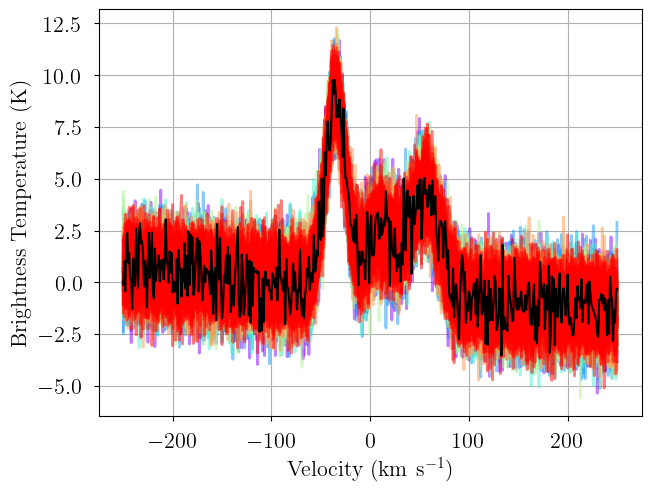

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

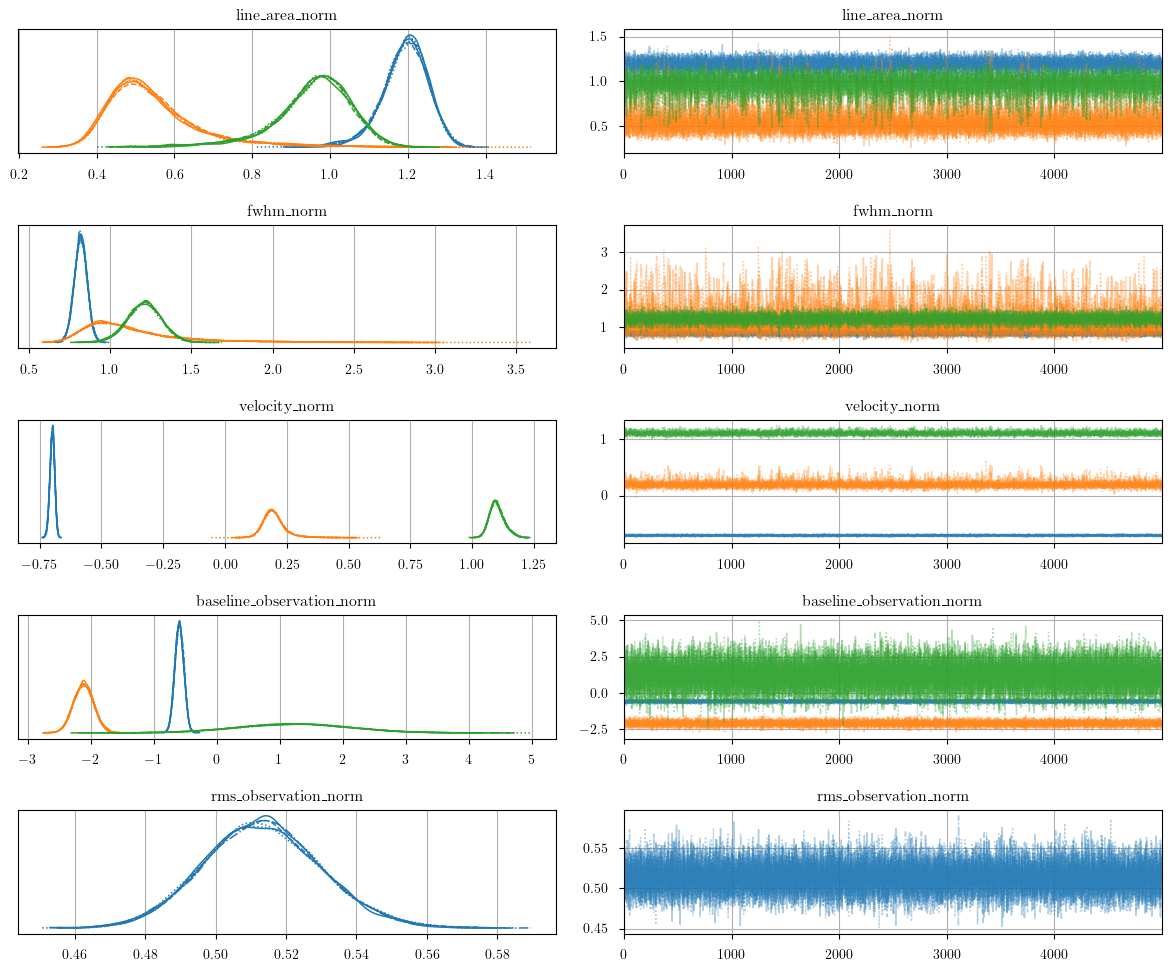

In [14]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [15]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.596   0.071   -0.726   -0.460      0.001   
baseline_observation_norm[1]   -2.116   0.160   -2.406   -1.808      0.001   
baseline_observation_norm[2]    1.222   0.881   -0.420    2.881      0.006   
line_area_norm_log__[0]         0.000   0.316   -0.737    0.275      0.122   
line_area_norm_log__[1]        -0.523   0.294   -0.928    0.062      0.089   
line_area_norm_log__[2]         0.024   0.148   -0.215    0.261      0.044   
fwhm_norm_log__[0]             -0.091   0.195   -0.313    0.291      0.066   
fwhm_norm_log__[1]              0.117   0.240   -0.316    0.580      0.005   
fwhm_norm_log__[2]              0.058   0.198   -0.270    0.321      0.075   
velocity_norm[0]               -0.699   0.010   -0.717   -0.681      0.000   
velocity_norm[1]                0.199   0.050    0.113    0.292      0.001   
velocity_norm[2]                1.101   0.031    1.046    1.164      0.000   
rms_observation_norm_log__     -0.667   0.032   -0.727   -0.605      0.000   
line_area_norm[0]               1.192   0.060    1.078    1.301      0.001   
line_area_norm[1]               0.550   0.130    0.355    0.799      0.002   
line_area_norm[2]               0.956   0.103    0.755    1.135      0.002   
fwhm_norm[0]                    0.819   0.040    0.745    0.894      0.000   
fwhm_norm[1]                    1.143   0.333    0.687    1.790      0.005   
fwhm_norm[2]                    1.210   0.106    1.011    1.409      0.001   
rms_observation_norm            0.513   0.017    0.483    0.546      0.000   
line_area[0]                  238.472  11.981  215.549  260.170      0.145   
line_area[1]                  109.920  25.972   71.085  159.715      0.414   
line_area[2]                  191.237  20.560  150.917  226.946      0.304   
fwhm[0]                        24.556   1.185   22.347   26.819      0.012   
fwhm[1]                        34.277   9.993   20.610   53.695      0.160   
fwhm[2]                        36.303   3.168   30.333   42.274      0.038   
velocity[0]                   -34.952   0.481  -35.847  -34.035      0.004   
velocity[1]                     9.969   2.482    5.662   14.625      0.032   
velocity[2]                    55.046   1.550   52.321   58.177      0.020   
amplitude[0]                    9.127   0.315    8.549    9.733      0.002   
amplitude[1]                    3.062   0.307    2.503    3.654      0.003   
amplitude[2]                    4.947   0.324    4.361    5.524      0.004   
rms_observation                 1.027   0.033    0.967    1.092      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   20157.0   22590.0   1.00  
baseline_observation_norm[1]    0.001   45748.0   22235.0   1.00  
baseline_observation_norm[2]    0.004   24482.0   24305.0   1.00  
line_area_norm_log__[0]         0.101       9.0      23.0   1.70  
line_area_norm_log__[1]         0.049      16.0      40.0   1.29  
line_area_norm_log__[2]         0.003      10.0      63.0   1.57  
fwhm_norm_log__[0]              0.033      12.0      68.0   1.45  
fwhm_norm_log__[1]              0.012     282.0    3946.0   1.03  
fwhm_norm_log__[2]              0.022      10.0      69.0   1.61  
velocity_norm[0]                0.000   13007.0   15219.0   1.00  
velocity_norm[1]                0.001    8862.0    5652.0   1.00  
velocity_norm[2]                0.000    6516.0    6689.0   1.00  
rms_observation_norm_log__      0.000   40889.0   20830.0   1.00  
line_area_norm[0]               0.001    7866.0    7096.0   1.00  
line_area_norm[1]               0.003    5382.0    4491.0   1.00  
line_area_norm[2]               0.002    5806.0    4459.0   1.00  
fwhm_norm[0]                    0.000    9641.0   12253.0   1.00  
fwhm_norm[1]                    0.007    5472.0    4714.0   1.00  
fwhm_norm[2]                    0.001    6920.0    7422.0   1.00  
rms_observation_norm            0.000   

## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [16]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [17]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Adding log-likelihood to trace


Output()

In [18]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [0 2 1]
Chain 1 order: [1 2 0]
Chain 2 order: [1 0 2]
Chain 3 order: [1 0 2]
Chain 4 order: [2 1 0]
Chain 5 order: [0 2 1]
Adopting (first) most common order: [0 2 1]


Sampling: [observation]


Output()

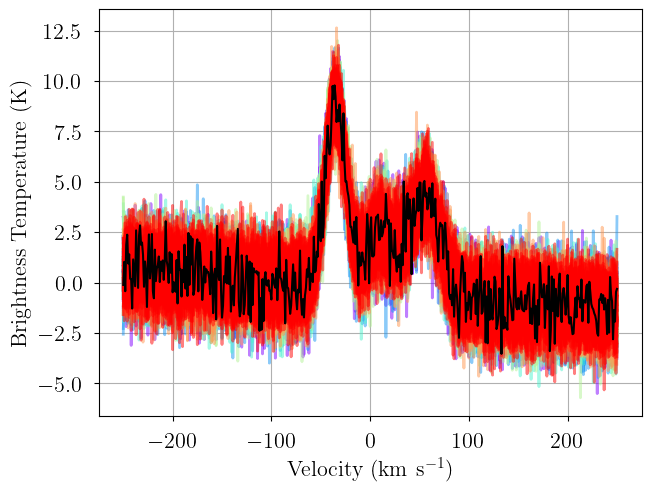

In [19]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

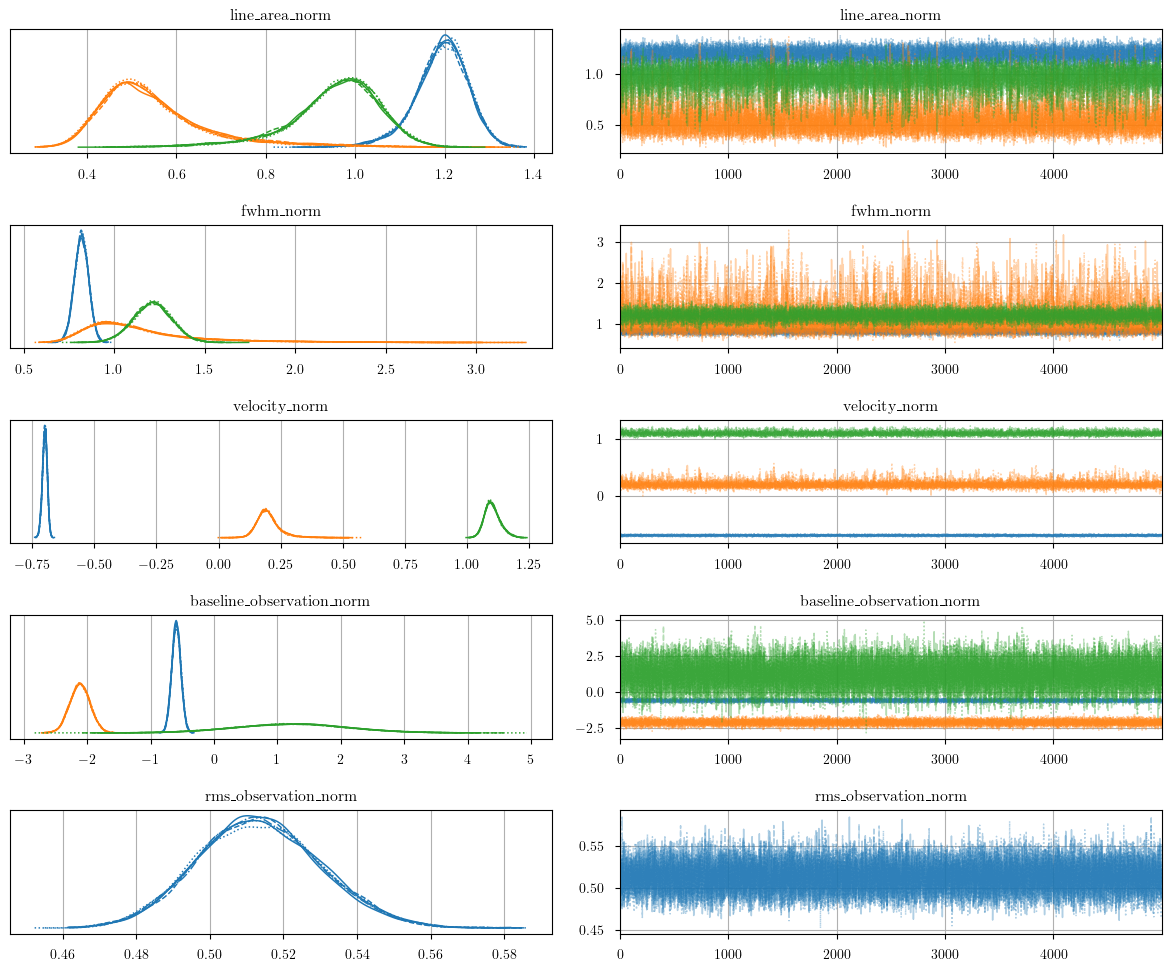

In [20]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [21]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.596   0.072   -0.729   -0.459      0.001   
baseline_observation_norm[1]   -2.118   0.158   -2.409   -1.817      0.001   
baseline_observation_norm[2]    1.219   0.884   -0.442    2.885      0.006   
velocity_norm[0]               -0.699   0.010   -0.718   -0.681      0.000   
velocity_norm[1]                0.200   0.050    0.114    0.293      0.001   
velocity_norm[2]                1.102   0.031    1.045    1.163      0.000   
line_area_norm[0]               1.192   0.060    1.079    1.305      0.001   
line_area_norm[1]               0.552   0.132    0.354    0.811      0.002   
line_area_norm[2]               0.955   0.104    0.755    1.140      0.001   
fwhm_norm[0]                    0.818   0.039    0.749    0.897      0.000   
fwhm_norm[1]                    1.149   0.338    0.678    1.808      0.005   
fwhm_norm[2]                    1.210   0.106    1.015    1.416      0.001   
rms_observation_norm            0.513   0.017    0.482    0.544      0.000   
line_area[0]                  238.348  12.072  215.752  261.022      0.145   
line_area[1]                  110.411  26.377   70.851  162.112      0.401   
line_area[2]                  191.044  20.752  150.924  228.060      0.293   
fwhm[0]                        24.549   1.179   22.460   26.896      0.012   
fwhm[1]                        34.458  10.134   20.353   54.233      0.156   
fwhm[2]                        36.305   3.190   30.450   42.477      0.037   
velocity[0]                   -34.960   0.484  -35.904  -34.074      0.005   
velocity[1]                    10.004   2.509    5.701   14.660      0.031   
velocity[2]                    55.080   1.574   52.232   58.171      0.020   
amplitude[0]                    9.125   0.315    8.543    9.723      0.002   
amplitude[1]                    3.060   0.308    2.502    3.660      0.003   
amplitude[2]                    4.942   0.326    4.333    5.516      0.004   
rms_observation                 1.027   0.033    0.964    1.089      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   19064.0   20997.0    1.0  
baseline_observation_norm[1]    0.001   28603.0   21191.0    1.0  
baseline_observation_norm[2]    0.005   19853.0   19365.0    1.0  
velocity_norm[0]                0.000   11021.0   13980.0    1.0  
velocity_norm[1]                0.001    9376.0    5935.0    1.0  
velocity_norm[2]                0.000    6875.0    6853.0    1.0  
line_area_norm[0]               0.001    7918.0    7023.0    1.0  
line_area_norm[1]               0.002    5811.0    5001.0    1.0  
line_area_norm[2]               0.001    6221.0    4925.0    1.0  
fwhm_norm[0]                    0.000    9911.0   11133.0    1.0  
fwhm_norm[1]                    0.006    5804.0    4968.0    1.0  
fwhm_norm[2]                    0.001    7502.0    8571.0    1.0  
rms_observation_norm            0.000   27174.0   20286.0    1.0  
line_area[0]                    0.130    7918.0    7023.0    1.0  
line_area[1]                    0.469    5811.0    5001.0    1.0  
line_area[2]                    0.298    6221.0    4925.0    1.0  
fwhm[0]                         0.008    9911.0   11133.0    1.0  
fwhm[1]                         0.183    5804.0    4968.0    1.0  
fwhm[2]                         0.023    7502.0    8571.0    1.0  
velocity[0]                     0.003   11021.0   13980.0    1.0  
velocity[1]                     0.044    9376.0    5935.0    1.0  
velocity[2]                     0.014    6875.0    6853.0    1.0  
amplitude[0]                    0.002   21531.0   16302.0    1.0  
amplitude[1]                    0.002   14520.0   20547.0    1.0  
amplitude[2]                    0.005   10943.0    6363.0    1.0  
rms_observation                 0.000   27174.0   20286.0    1.0

## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [22]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

Running window adaptation


Output()

Adding log-likelihood to trace


In [23]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 2 0]
Chain 1 order: [2 0 1]
Chain 2 order: [2 0 1]
Chain 3 order: [2 1 0]
Chain 4 order: [0 2 1]
Chain 5 order: [1 0 2]
Adopting (first) most common order: [2 0 1]


Sampling: [observation]


Output()

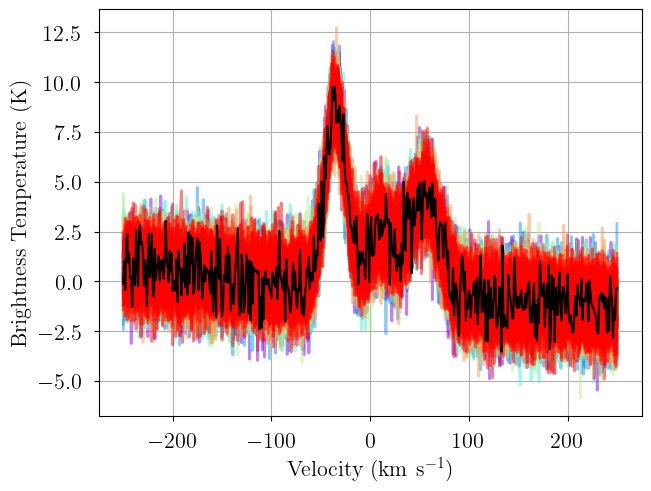

In [24]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

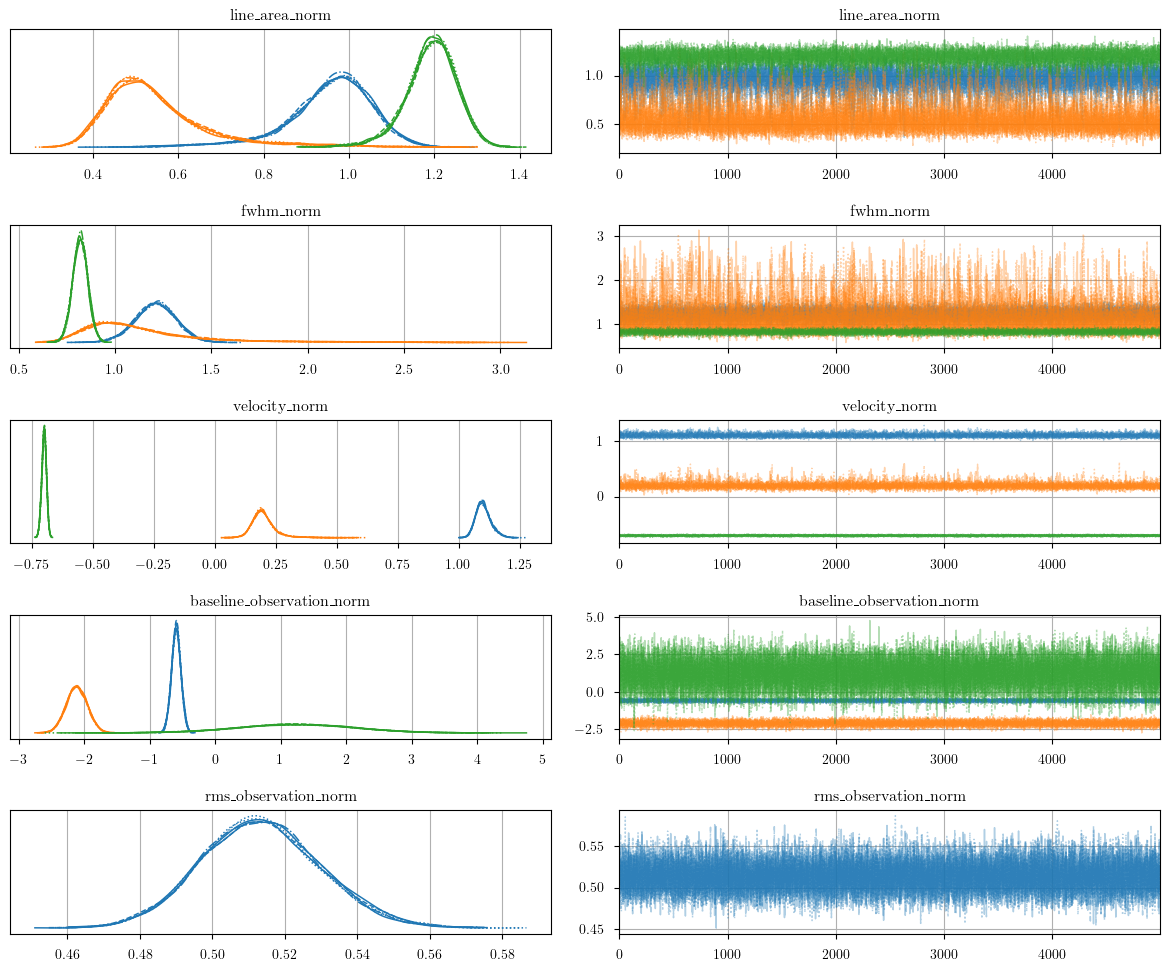

In [25]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [26]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.596   0.072   -0.737   -0.465      0.001   
baseline_observation_norm[1]   -2.116   0.159   -2.409   -1.814      0.001   
baseline_observation_norm[2]    1.226   0.878   -0.388    2.920      0.006   
velocity_norm[0]                1.101   0.031    1.044    1.161      0.000   
velocity_norm[1]                0.200   0.050    0.114    0.291      0.001   
velocity_norm[2]               -0.699   0.010   -0.717   -0.681      0.000   
line_area_norm[0]               0.956   0.103    0.753    1.135      0.002   
line_area_norm[1]               0.550   0.129    0.359    0.800      0.002   
line_area_norm[2]               1.193   0.060    1.079    1.302      0.001   
fwhm_norm[0]                    1.210   0.105    1.012    1.409      0.001   
fwhm_norm[1]                    1.142   0.331    0.685    1.781      0.005   
fwhm_norm[2]                    0.819   0.039    0.744    0.893      0.000   
rms_observation_norm            0.513   0.016    0.484    0.546      0.000   
line_area[0]                  191.204  20.512  150.518  226.933      0.304   
line_area[1]                  109.929  25.792   71.832  160.038      0.409   
line_area[2]                  238.574  11.939  215.743  260.358      0.143   
fwhm[0]                        36.309   3.158   30.373   42.270      0.038   
fwhm[1]                        34.251   9.939   20.547   53.442      0.158   
fwhm[2]                        24.559   1.180   22.323   26.786      0.012   
velocity[0]                    55.048   1.544   52.218   58.048      0.020   
velocity[1]                     9.990   2.475    5.716   14.568      0.032   
velocity[2]                   -34.956   0.478  -35.861  -34.059      0.005   
amplitude[0]                    4.946   0.327    4.362    5.538      0.004   
amplitude[1]                    3.064   0.306    2.469    3.615      0.002   
amplitude[2]                    9.130   0.313    8.547    9.718      0.002   
rms_observation                 1.027   0.033    0.968    1.092      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   18738.0   20394.0    1.0  
baseline_observation_norm[1]    0.001   28825.0   20036.0    1.0  
baseline_observation_norm[2]    0.005   20196.0   21571.0    1.0  
velocity_norm[0]                0.000    6491.0    6272.0    1.0  
velocity_norm[1]                0.001    8827.0    5487.0    1.0  
velocity_norm[2]                0.000   11078.0   14163.0    1.0  
line_area_norm[0]               0.002    5868.0    4532.0    1.0  
line_area_norm[1]               0.003    5545.0    4464.0    1.0  
line_area_norm[2]               0.001    7921.0    6922.0    1.0  
fwhm_norm[0]                    0.001    7125.0    6838.0    1.0  
fwhm_norm[1]                    0.007    5619.0    4486.0    1.0  
fwhm_norm[2]                    0.000    9498.0   11242.0    1.0  
rms_observation_norm            0.000   24977.0   20687.0    1.0  
line_area[0]                    0.330    5868.0    4532.0    1.0  
line_area[1]                    0.514    5545.0    4464.0    1.0  
line_area[2]                    0.129    7921.0    6922.0    1.0  
fwhm[0]                         0.024    7125.0    6838.0    1.0  
fwhm[1]                         0.196    5619.0    4486.0    1.0  
fwhm[2]                         0.008    9498.0   11242.0    1.0  
velocity[0]                     0.014    6491.0    6272.0    1.0  
velocity[1]                     0.050    8827.0    5487.0    1.0  
velocity[2]                     0.003   11078.0   14163.0    1.0  
amplitude[0]                    0.005   10541.0    5862.0    1.0  
amplitude[1]                    0.002   14906.0   18855.0    1.0  
amplitude[2]                    0.002   22762.0   15196.0    1.0  
rms_observation                 0.000   24977.0   20687.0    1.0

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [27]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Output()

Adding log-likelihood to trace


In [28]:
model.solve()

No solution found!
0 of 8 chains appear converged.


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

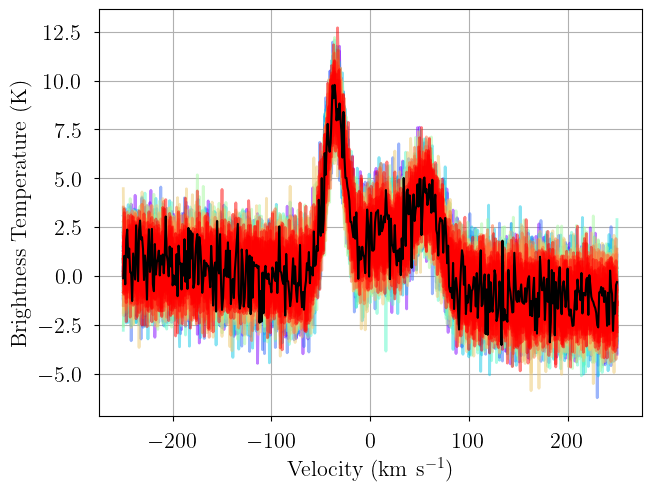

In [29]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

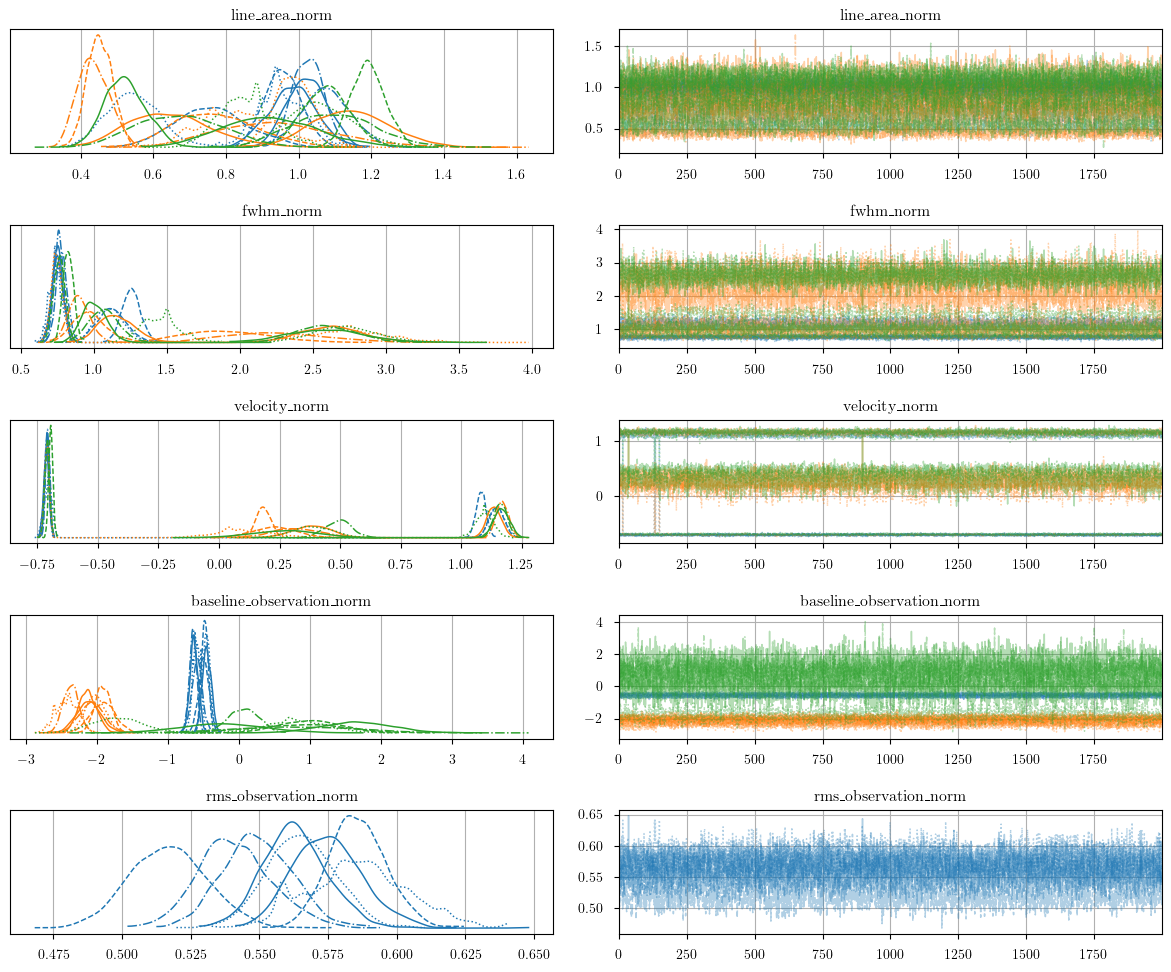

In [31]:
axes = plot_traces(model.trace.posterior, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussNoiseModel` has an option to do just this: `add_priors(ordered=True)`. Note that this changes the definition of the prior distribution on `velocity`. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [32]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
    ordered = True, # enforce ordered velocities
)
model.add_likelihood()

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, rms_observation_norm, velocity_norm]


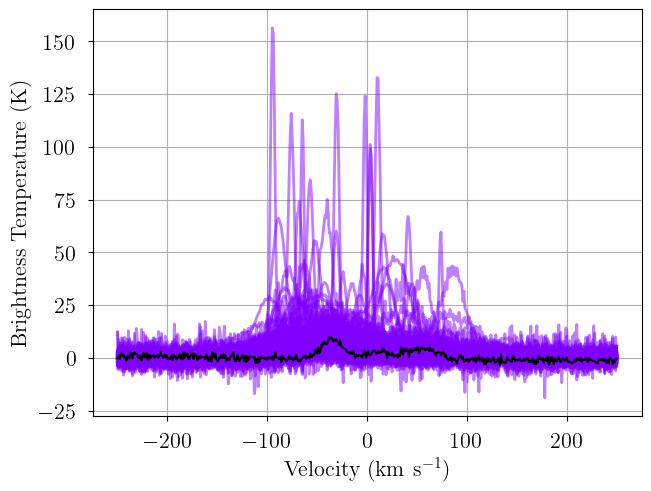

In [33]:
# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [34]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: 
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 
likely lead to a deadlock.
  self.pid = os.fork()

Output()

Adding log-likelihood to trace


In [35]:
model.solve()

GMM converged to unique solution


Sampling: [observation]


Output()

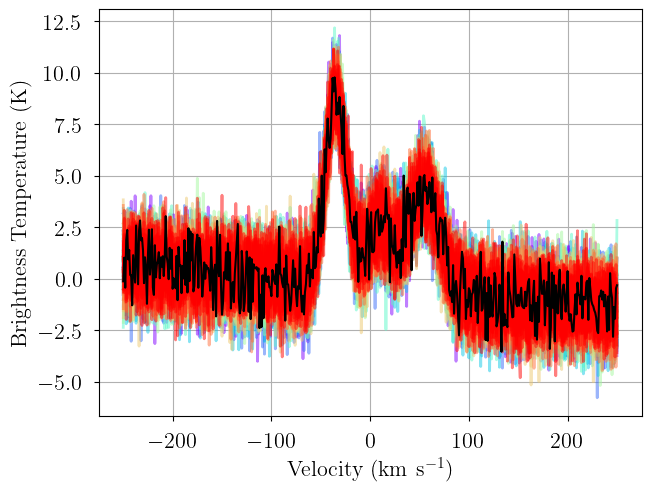

In [36]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

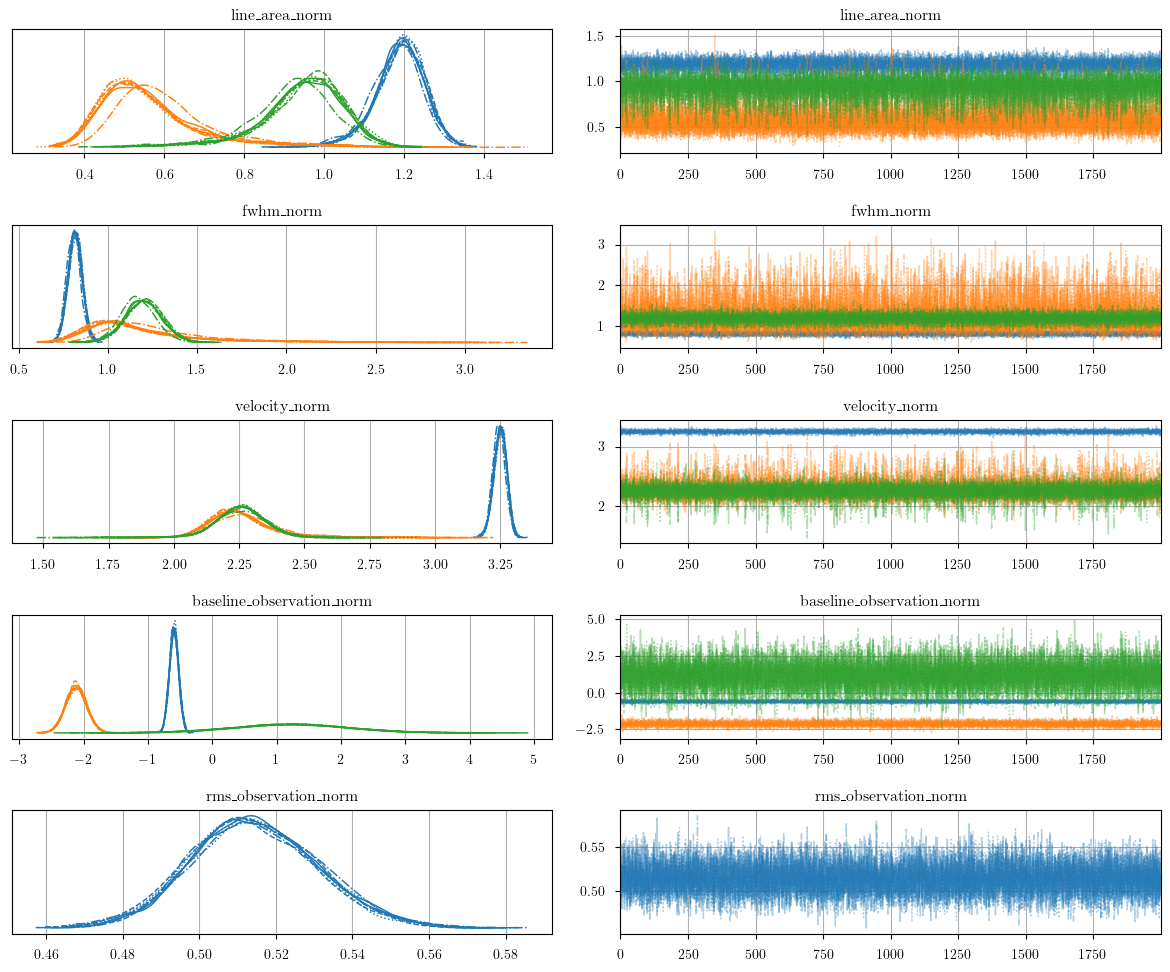

In [37]:
axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

In [38]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_observation_norm[0]   -0.594   0.071   -0.726   -0.457      0.001   
baseline_observation_norm[1]   -2.116   0.159   -2.414   -1.813      0.001   
baseline_observation_norm[2]    1.217   0.882   -0.460    2.866      0.007   
line_area_norm[0]               1.187   0.063    1.069    1.304      0.001   
line_area_norm[1]               0.569   0.136    0.366    0.838      0.003   
line_area_norm[2]               0.943   0.107    0.732    1.131      0.001   
fwhm_norm[0]                    0.815   0.040    0.740    0.889      0.000   
fwhm_norm[1]                    1.198   0.351    0.727    1.917      0.008   
fwhm_norm[2]                    1.196   0.105    0.993    1.389      0.002   
velocity_norm[0]                3.250   0.024    3.204    3.295      0.000   
velocity_norm[1]                2.260   0.138    2.026    2.510      0.001   
velocity_norm[2]                2.254   0.105    2.078    2.453      0.001   
rms_observation_norm            0.514   0.016    0.485    0.546      0.000   
line_area[0]                  237.413  12.534  213.872  260.810      0.104   
line_area[1]                  113.790  27.292   73.285  167.513      0.681   
line_area[2]                  188.552  21.387  146.418  226.121      0.238   
fwhm[0]                        24.442   1.187   22.203   26.660      0.010   
fwhm[1]                        35.928  10.527   21.811   57.523      0.248   
fwhm[2]                        35.883   3.145   29.796   41.667      0.068   
velocity[0]                   -35.008   0.489  -35.918  -34.102      0.004   
velocity[1]                    10.189   2.668    5.703   15.208      0.022   
velocity[2]                    55.265   1.566   52.400   58.322      0.038   
amplitude[0]                    9.129   0.324    8.507    9.718      0.003   
amplitude[1]                    3.023   0.299    2.481    3.597      0.003   
amplitude[2]                    4.933   0.346    4.303    5.546      0.003   
rms_observation                 1.029   0.033    0.969    1.093      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline_observation_norm[0]    0.000   15975.0   15713.0   1.00  
baseline_observation_norm[1]    0.001   16452.0   15726.0   1.00  
baseline_observation_norm[2]    0.005   16066.0   15777.0   1.00  
line_area_norm[0]               0.000   14485.0   15189.0   1.00  
line_area_norm[1]               0.001     648.0   15225.0   1.01  
line_area_norm[2]               0.001    3878.0   15234.0   1.01  
fwhm_norm[0]                    0.000   14023.0   15452.0   1.00  
fwhm_norm[1]                    0.003     402.0   14177.0   1.02  
fwhm_norm[2]                    0.001    1935.0   15687.0   1.01  
velocity_norm[0]                0.000   13688.0   14825.0   1.00  
velocity_norm[1]                0.002   15285.0   14949.0   1.00  
velocity_norm[2]                0.001   15481.0   14871.0   1.00  
rms_observation_norm            0.000   15252.0   13978.0   1.00  
line_area[0]                    0.086   14485.0   15189.0   1.00  
line_area[1]                    0.267     648.0   15225.0   1.01  
line_area[2]                    0.175    3878.0   15234.0   1.01  
fwhm[0]                         0.007   14023.0   15452.0   1.00  
fwhm[1]                         0.103     402.0   14177.0   1.02  
fwhm[2]                         0.019    1935.0   15687.0   1.01  
velocity[0]                     0.003   13688.0   14825.0   1.00  
velocity[1]                     0.030   15616.0   15139.0   1.00  
velocity[2]                     0.009    1515.0   14976.0   1.01  
amplitude[0]                    0.002   15012.0   15792.0   1.00  
amplitude[1]                    0.002    8913.0   14764.0   1.01  
amplitude[2]                    0.004   15667.0   14917.0   1.00  
rms_observation                 0.000   15252.0   13978.0   1.00